In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

import torch

from clusterless.utils import NP1DataLoader, ADVIDataLoader, fit_initial_gmm
from clusterless.encoder import ADVI

from clusterless.decoder import dynamic_decoder, sliding_window_decoder

In [11]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [12]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### load data

In [13]:
np1_data_loader = NP1DataLoader(
    probe_id = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0', 
    geom_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016/np1_channel_map.npy', 
    ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016/subtraction_results_threshold_5', 
    behavior_path = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/original_data'
)

Session ID: db4df448-e449-4a6f-a0e7-288711e7a75a
Probe ID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 (probe00)
First trial stimulus onset time: 40.81 sec
Last trial stimulus onset time: 2252.10 sec


In [5]:
# np1_data_loader = NP1DataLoader(
#     probe_id = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943', 
#     geom_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/np1_channel_map.npy', 
#     # ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/subtraction_results_threshold_5', 
#     ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/subtract_res_wf_pcs', 
#     behavior_path = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/original_data'
# )

In [6]:
trials = np1_data_loader.load_spike_features(region = 'vis')

Found 28 channels in region vis


In [7]:
# trials = np1_data_loader.relocalize_kilosort(
#     data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/kilosort_localizations',
#     region = 'ca1')

In [8]:
trials[-1].max(0)

array([2311.24108857,  377.        ,   76.18935394, 3788.89624023,
         17.82670975])

In [9]:
motion_energy, wheel_velocity, wheel_speed, paw_speed, nose_speed, pupil_diameter = \
    np1_data_loader.load_behaviors('dynamic')

In [10]:
advi_data_loader = ADVIDataLoader(
                         data = trials, 
                         # behavior = motion_energy, 
                         behavior = wheel_speed, 
                         n_t_bins = 30)

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
kf_train_ids = []
kf_test_ids = []
for i, (train_ids, test_ids) in enumerate(kf.split(advi_data_loader.behavior)):
    kf_train_ids.append(train_ids)
    kf_test_ids.append(test_ids)

In [12]:
i = 0
train_trials, train_trial_ids, train_time_ids, test_trials, test_trial_ids, test_time_ids = \
    advi_data_loader.split_train_test(kf_train_ids[i], kf_test_ids[i])

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [13]:
train_trials.max(0)

array([ 383.        ,  110.04499817, 3900.        ,   22.63020134])

In [14]:
gmm = fit_initial_gmm(np.vstack([train_trials, test_trials]))

Channel 356 is split into 1 modes
Channel 357 is split into 1 modes
Channel 358 is split into 1 modes
Channel 359 is split into 1 modes
Channel 360 is split into 1 modes
Channel 361 is split into 1 modes
Channel 362 is split into 2 modes
Channel 363 is split into 2 modes
Channel 364 is split into 1 modes
Channel 365 is split into 1 modes
Channel 366 is split into 2 modes
Channel 367 is split into 1 modes
Channel 368 is split into 1 modes
Channel 369 is split into 1 modes
Channel 370 is split into 1 modes
Channel 371 is split into 1 modes
Channel 372 is split into 1 modes
Channel 373 is split into 1 modes
Channel 374 is split into 1 modes
Channel 375 is split into 1 modes
Channel 376 is split into 1 modes
Channel 377 is split into 1 modes
Channel 378 is split into 1 modes
Channel 379 is split into 1 modes
Channel 381 is split into 1 modes
Channel 382 is split into 1 modes
Channel 383 is split into 1 modes


In [15]:
s = torch.tensor(train_trials[:,1:])
y = torch.tensor(advi_data_loader.behavior)
ks = torch.tensor(train_trial_ids)
ts = torch.tensor(train_time_ids)

Nk = len(advi_data_loader.train_ids)
Nt = advi_data_loader.n_t_bins
Nc = gmm.means_.shape[0]
Nd = gmm.means_.shape[1]
print(Nc)

30


#### ADVI

In [16]:
batch_size = 1
batch_ids = list(zip(*(iter(advi_data_loader.train_ids),) * batch_size))

In [17]:
advi = ADVI(batch_size, Nt, Nc, Nd, gmm.means_, gmm.covariances_)
optim = torch.optim.Adam(advi.parameters(), lr=1e-2)

In [18]:
%%time
elbos = advi.train_advi(s, y, ks, ts, batch_ids, optim, max_iter=30)

iter: 1 batch 100
iter: 1 batch 200
iter: 1 total elbo: -31.80
iter: 2 batch 100
iter: 2 batch 200
iter: 2 total elbo: -16.19
iter: 3 batch 100
iter: 3 batch 200
iter: 3 total elbo: -13.24
iter: 4 batch 100
iter: 4 batch 200
iter: 4 total elbo: -12.47
iter: 5 batch 100
iter: 5 batch 200
iter: 5 total elbo: -12.09
iter: 6 batch 100
iter: 6 batch 200
iter: 6 total elbo: -11.83
iter: 7 batch 100
iter: 7 batch 200
iter: 7 total elbo: -11.75
iter: 8 batch 100
iter: 8 batch 200
iter: 8 total elbo: -11.66
iter: 9 batch 100
iter: 9 batch 200
iter: 9 total elbo: -11.64
iter: 10 batch 100
iter: 10 batch 200
iter: 10 total elbo: -11.62
iter: 11 batch 100
iter: 11 batch 200
iter: 11 total elbo: -11.57
iter: 12 batch 100
iter: 12 batch 200
iter: 12 total elbo: -11.58
iter: 13 batch 100
iter: 13 batch 200
iter: 13 total elbo: -11.54
iter: 14 batch 100
iter: 14 batch 200
iter: 14 total elbo: -11.53
iter: 15 batch 100
iter: 15 batch 200
iter: 15 total elbo: -11.53
iter: 16 batch 100
iter: 16 batch 200

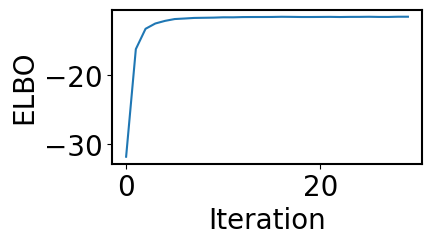

In [19]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [20]:
pis = advi.calc_dynamic_mixing_proportions(y)

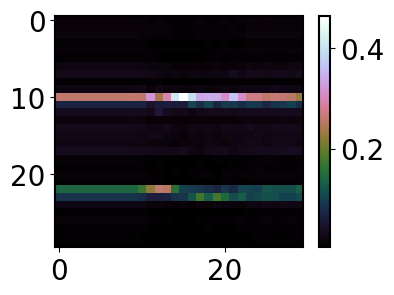

In [21]:
plt.figure(figsize=(4,3))
plt.imshow(pis.mean(0), aspect='auto', cmap='cubehelix')
plt.colorbar();

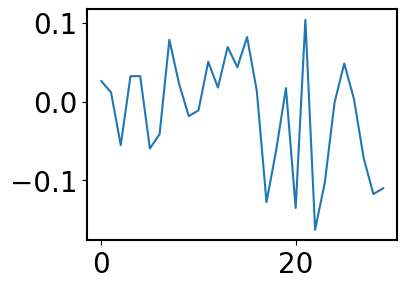

In [22]:
plt.figure(figsize=(4,3))
plt.plot(advi.beta.loc[1].detach().numpy());

#### GMM

In [23]:
train = advi_data_loader.train_ids
test = advi_data_loader.test_ids

In [24]:
spike_train = np.concatenate(trials)
spike_times = spike_train[:,0]
spike_labels = gmm.predict(spike_train[:,2:])
spike_probs = gmm.predict_proba(spike_train[:,2:])

vanilla_gmm = np1_data_loader.prepare_decoder_input(
    np.c_[spike_times, spike_labels, spike_probs],
    is_gmm = True, n_t_bins = 30, regional = True)
print(vanilla_gmm.shape)

(265, 30, 30)


R2: -0.006, MSE: 0.988, Corr: 0.675


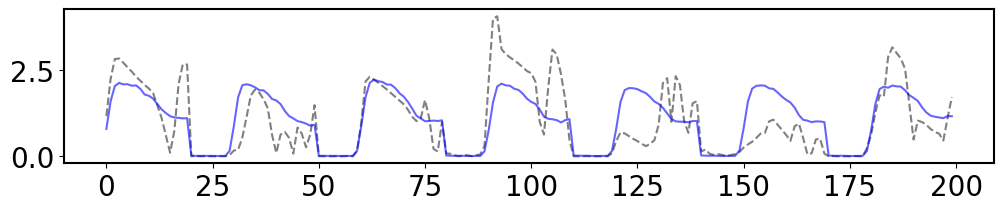

In [25]:
y_train, y_test, y_pred = dynamic_decoder(vanilla_gmm, advi_data_loader.behavior, train, test)

plt.figure(figsize=(12, 2))
plt.plot(y_test.flatten()[-200:], c='gray', linestyle='dashed');
plt.plot(y_pred.flatten()[-200:], c='blue', alpha=.6);

R2: 0.224, MSE: 1.479, Corr: 0.507


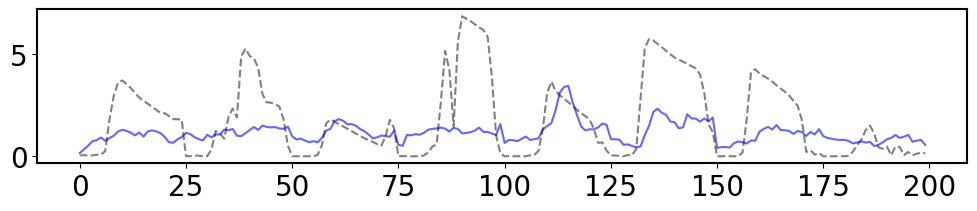

In [26]:
y_train, y_test, y_pred = sliding_window_decoder(vanilla_gmm, advi_data_loader.behavior, train, test)

plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### multi-unit thresholding

In [27]:
spike_train = np.concatenate(trials)
spike_times = spike_train[:,0]
spike_channels = spike_train[:,1]

thresholded = np1_data_loader.prepare_decoder_input(
    np.c_[spike_times, spike_channels],
    is_gmm = False, n_t_bins = 30, regional = True)
print(thresholded.shape)

(265, 27, 30)


R2: -0.008, MSE: 0.990, Corr: 0.674


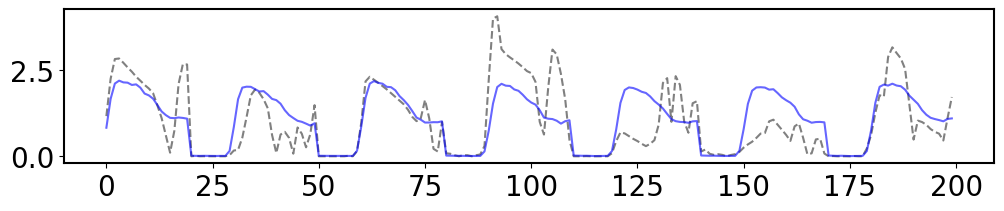

In [30]:
y_train, y_test, y_pred = dynamic_decoder(thresholded, advi_data_loader.behavior, train, test)

plt.figure(figsize=(12, 2))
plt.plot(y_test.flatten()[-200:], c='gray', linestyle='dashed');
plt.plot(y_pred.flatten()[-200:], c='blue', alpha=.6);

R2: 0.212, MSE: 1.501, Corr: 0.493


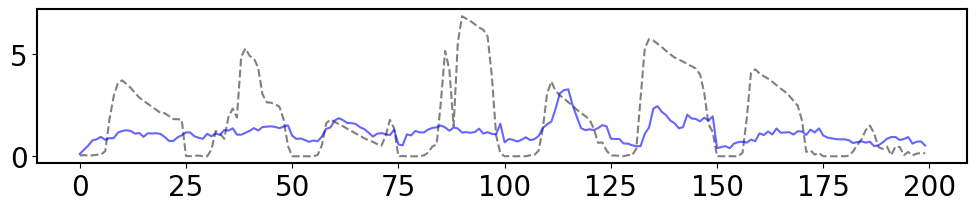

In [29]:
y_train, y_test, y_pred = sliding_window_decoder(thresholded, advi_data_loader.behavior, train, test)

plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### encoding MoG

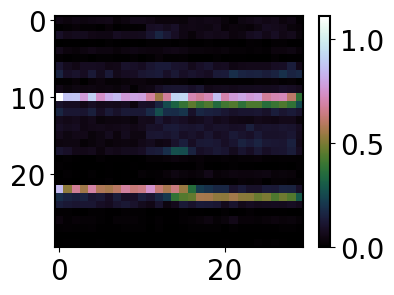

In [31]:
enc_pis, enc_all = advi.encode_gmm(advi_data_loader.trials, train, test, y_train, y_pred)

plt.figure(figsize=(4,3))
plt.imshow(enc_all.mean(0), aspect='auto', cmap='cubehelix')
plt.colorbar();

R2: -0.004, MSE: 0.986, Corr: 0.676


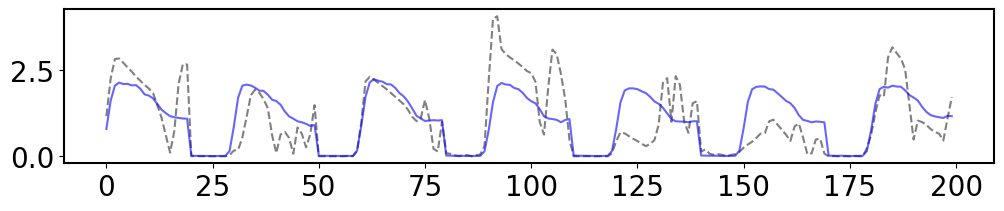

In [32]:
y_train, y_test, y_pred = dynamic_decoder(enc_all, advi_data_loader.behavior, train, test)

plt.figure(figsize=(12, 2))
plt.plot(y_test.flatten()[-200:], c='gray', linestyle='dashed');
plt.plot(y_pred.flatten()[-200:], c='blue', alpha=.6);

R2: 0.230, MSE: 1.468, Corr: 0.512


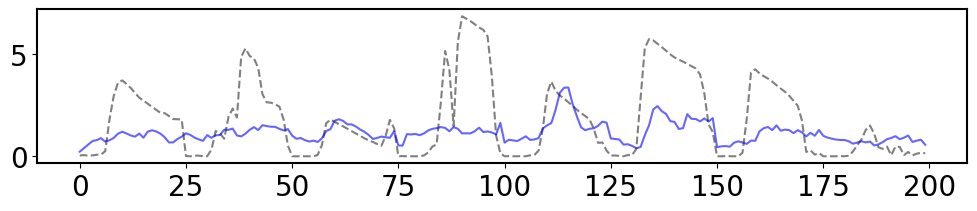

In [33]:
y_train, y_test, y_pred = sliding_window_decoder(enc_all, advi_data_loader.behavior, train, test)

plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### KS all units

In [34]:
ks_all = np1_data_loader.load_all_units(region='po')
ks_all = np.concatenate(ks_all)

all_units = np1_data_loader.prepare_decoder_input(
    ks_all,
    is_gmm = False, n_t_bins = 30, regional = True)
print(all_units.shape)

Found 163 KS units in region po
(265, 159, 30)


R2: 0.133, MSE: 0.782, Corr: 0.764


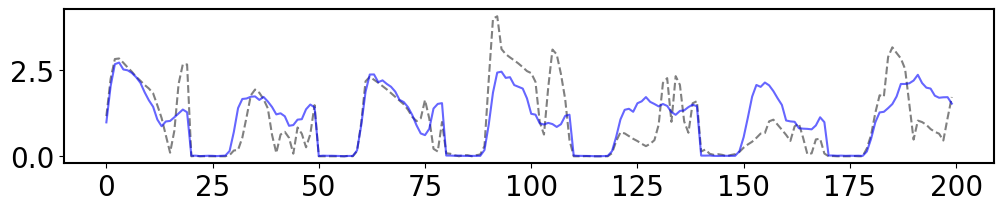

In [35]:
y_train, y_test, y_pred = dynamic_decoder(all_units, advi_data_loader.behavior, train, test)

plt.figure(figsize=(12, 2))
plt.plot(y_test.flatten()[-200:], c='gray', linestyle='dashed');
plt.plot(y_pred.flatten()[-200:], c='blue', alpha=.6);

R2: 0.412, MSE: 1.121, Corr: 0.647


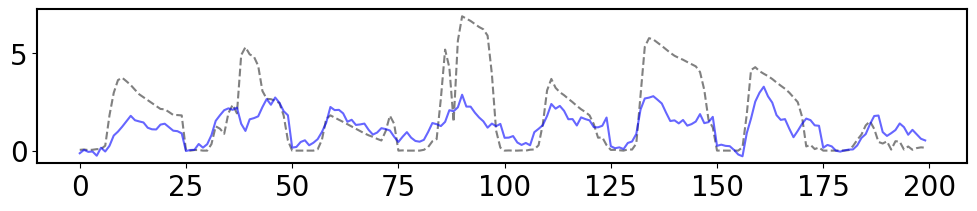

In [36]:
y_train, y_test, y_pred = sliding_window_decoder(all_units, advi_data_loader.behavior, train, test)

plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### KS good units

In [37]:
ks_good = np1_data_loader.load_good_units(region='po')
ks_good = np.concatenate(ks_good)

good_units = np1_data_loader.prepare_decoder_input(
    ks_good,
    is_gmm = False, n_t_bins = 30, regional = True)
print(good_units.shape)

Found 24 good units in region po
(265, 24, 30)


R2: 0.096, MSE: 0.825, Corr: 0.746


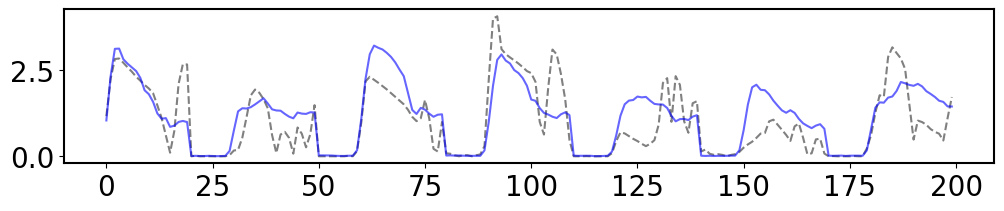

In [38]:
y_train, y_test, y_pred = dynamic_decoder(good_units, advi_data_loader.behavior, train, test)

plt.figure(figsize=(12, 2))
plt.plot(y_test.flatten()[-200:], c='gray', linestyle='dashed');
plt.plot(y_pred.flatten()[-200:], c='blue', alpha=.6);

R2: 0.397, MSE: 1.148, Corr: 0.639


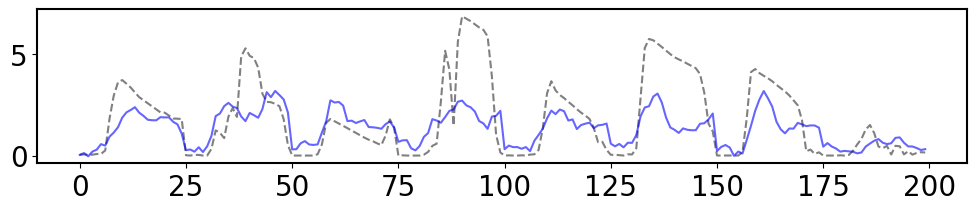

In [39]:
y_train, y_test, y_pred = sliding_window_decoder(good_units, advi_data_loader.behavior, train, test)

plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');